# Загрузка Pandas и очистка данных

In [4]:
import pandas as pd
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 10000)

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Проект модуля 3. О вкусной и здоровой пище

## Цель: Построить модель, предсказывающую рейтинг ресторана

## План
1. Проанализировать данные, определить направления их улучшения
2. Обработать пропуски, выбросы, придумать дополнительные признаки
3. Разбить датасет на тренриовочную и боевые части
4. Обучить и валидировать модель

## Исходные данные
- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvosor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

## Библиотека служебных функций

In [6]:
# Функция для создания словарей из слов, использованных в отзывах (для последующего ранжирования отзывов)
def make_dict(df,col):
    collection = {}
    for string in df[col]:
        for word in string:
            if word in collection.keys():
                collection[word]+=1
            else:
                collection[word] =1
    return collection

df=pd.read_csv('main_task.csv')
df['Reviews']=df['Reviews'].apply(lambda x: x.lower())
pattern = re.compile('[a-z]*')
df['new'] = df['Reviews'].apply(pattern.findall)
words = pd.Series(make_dict(df,'new')).drop('').sort_values(ascending=False)
# Из полученного словаря берем 1000 наиболее употребимых слов и создаенм два списка: positive и negative.
# Списки сохраняем в txt файлы: Negative_reviews.txt и Positive_reviews.txt

# После того, как забрали слова - убираем поле new
df.drop(columns=['new'], inplace=True)

# Функция file_read cчитывает слова с негативной и позитивной окраской из файлов Negative_reviews.txt и Positive_reviews.txt
def file_read(file_name):
    import csv
    with open(file_name) as File:
        reader = csv.reader(File)
        for line in reader:
            words = line
        return words

In [7]:
# Функция marking считывает в соответствующие списики словари "хороших" и "плохих" оценок, 
# затем проверяет каждый элемент полученной в качестве параметра серии и формирует соответствующую оценку (1 или -1)
# в поля negative и positive.
# Затем формируется итоговое значение как сумма значений по полям positive и negative. 


def check_words(rev,words,mark):
    for w in words:
        df.loc[(df[rev].str.contains(w)) & ~(df[rev].str.contains('not')), 'negative'] = mark
        df.loc[(df[rev].str.contains(w)) &  (df[rev].str.contains('not')), 'positive'] = -mark
    return 0


def marking (rev,mark):
    negative = file_read('Negative_reviews.txt')
    positive = file_read('Positive_reviews.txt')
    df['positive'] = df['negative'] = 0

    check_words(rev,negative,-1)
    check_words(rev,positive, 1)
    
    df[mark]=df['positive']+df['negative']
    df.drop(columns = ['positive','negative'], inplace=True)
    return 0


def simple_list(string):
    string = string.lower()
    str_list = [i.strip("'[]") for i in string.split(', ')]
    return str_list

In [8]:
# Функции для обработки поля 'Cuisine Style'
def list_to_columns(df, col, not_a_list=False):
    if not_a_list:
        collection = df[col].unique()
    else:
        collection = make_collection(df,col)
    for i in collection:
        df[i] = df[col].apply(lambda x: 1 if (i in x) or (i=='other') else 0)
    return 0


def make_collection(df, col, not_a_list=False):
    collection = {}
    for i in df[col]:
        for j in i:
            if j in collection.keys():
                collection[j]+=1
            else:
                collection[j] =1
    collection = pd.Series(collection).sort_values(ascending=False).head(30).index.tolist() # Топ-30 стилей превышают 90 процентиль
    collection.append('other')
    return collection


def make_cuis_list (city, Cities, pos):
    cuislist=[]
    for cuis in Cities.columns[pos:]:
        if Cities.loc[city.name,cuis] != 0:
            cuislist.append(cuis)
    return cuislist


def make_pop_cuis (city, Cities, pos):
    result = list(Cities.loc[city.name, Cities.columns[pos:]].sort_values(ascending=False).head(city.cuis_per_rest).index)
    return result


def isnan(x):
    if x!=x: return True
    return False

# 1. Первый взгляд на данные

In [9]:
# 1. смотрим на данные
df = pd.read_csv('main_task.csv')
df.info()
display(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
16619,id_2311,Lisbon,"['European', 'Portuguese']",2314.0,4.5,$$ - $$$,16.0,"[['Nice lunch and nice service', 'Worst meal e...",/Restaurant_Review-g189158-d7648900-Reviews-Ge...,d7648900
11945,id_705,Edinburgh,"['Japanese', 'Sushi', 'Asian', 'Vegetarian Fri...",706.0,4.0,$$ - $$$,273.0,"[['Very Hearty and good value', 'Great dinner'...",/Restaurant_Review-g186525-d795391-Reviews-Bon...,d795391
22586,id_2928,Amsterdam,"['Lebanese', 'Mediterranean']",2937.0,4.5,NaN,17.0,"[['Pakistan buffet - nice and good tastes', 'G...",/Restaurant_Review-g188590-d6354097-Reviews-Ra...,d6354097
3145,id_1421,Hamburg,NaN,1423.0,4.5,NaN,10.0,"[[], []]",/Restaurant_Review-g187331-d10279161-Reviews-Y...,d10279161
2868,id_72,Oslo,"['European', 'Wine Bar', 'Scandinavian', 'Norw...",73.0,4.5,$$ - $$$,159.0,"[['Nice and professional', 'Great atmosphere a...",/Restaurant_Review-g190479-d691546-Reviews-Mar...,d691546


### План предобработки данных:
1. УКдаляю поля Restaurant_id и URL_TA (парсить пока не умею)
2. Поле Price Range обрабатываем на основании его значений (ранжируем на уровни 1,2 и 3), пропуски заполняем 0.
3. Поле Reviews:

    3.1. Создаем 4 новых поля: два отзыва + две даты. Там, где отзывов нет - оставляем пустые строки и служебную условную дату. Аналогично поступаем с отсутствующей информацией по строкам с одним отзывом.
    
    3.2. Обрабатываем поля с отзывами и получаем тональность отзывов. Формируем 4 новых поля:
    - по одному полю на оценку для каждого отзыва (1 за позитивный отзыв, -1 за негативный отзыв, 0 для смешанных или отсутствующих),
    - одно поле на суммарную оценку по двум отзывам,
    - одно поле для оценки динамики: 1 - если вторая оценка лучше первой (за исключением нулевых оценок), и -1, если наоборот.
    
   3.3. Обрабатываем даты отзывов и находим интервал между датами. Ожидаем, что date_1 > date_2. Внимательно смотрим на случаи, когда это неравенство не соблюдается. Возможно добавляем новое поле, характеризующее подобные вылеты /wrong_date/.
    
    
4. Пропуски в поле Number of Reviews заполним в зависимости от обработанного поля Reviews (медианным значением по городу, если обработанное Reviews не нулевое, или 0, если Reviews=0). Учитвая существенный разброс в поле Number of Reviews - заменим его на модификацию - возьмем логарифм.
5. Поле Cuisine Style:

   5.1. Определим все возможные стили. Возьмем стили, присутствующие в 80% ресторанов, остальные сгруппируем в одну группу.
   
   5.2. Сгруппируем датасет по городам и найдем:
      - среднее количество стилей на 1 ресторан в каждом городе,
      - самые популярные стили в каждом городе.
      
   5.3. На основании полученных данных заполним пропуски в исходном датасете - каждому ресторну с пропуском в поле Cuisine Style назначим характерное для его города число наиболее популярных в его городе стилей.
   
   5.4. Сформируем Dummy-переменные из стилей с заполненными пропусками.


6. Поле Cities: Сформируем Dummy-переменные из городов.
7. Поле Ranking нормируем по максимальному значению для своего города (Ri / Rmax in the city)
7. Дополнительную информацию точно можно спасить с сайта Tripadviser, но я пока не умею. Научусь немного позже.

# 2. Предобработка

In [10]:
# 1. Удаляем ненужные поля
df.drop(['Restaurant_id','ID_TA','URL_TA',], axis=1, inplace=True)
# я пока не умею парсить и нет времени на самостоятельное изучение. Вернусь после прохождения соответствующего модуля

In [11]:
# 2. Обработка поля 'Price Range'
df['Price Range'] = df['Price Range'].apply(lambda x: 0 if isnan(x) \
                                           else 1 if x=='$' \
                                           else 3 if x=='$$$$' \
                                           else 2)

In [12]:
# 3. Обработка поля 'Reviews' (обработка ячейки занимает около 1 минуты)

# Делим поле на поля с датой и с отзывами
# 3.1. Находим даты
pattern = re.compile('\d\d/\d\d/\d{4}')
df['dates']   = df['Reviews'].apply(pattern.findall)
df['d1'] = df['dates'].apply(lambda x: pd.to_datetime(x[0]) if len(x) >0 else pd.to_datetime('2001-01-01'))
df['d2'] = df['dates'].apply(lambda x: pd.to_datetime(x[1]) if len(x)==2 else pd.to_datetime('2001-01-01'))

df['d_len']   = df['dates'].apply(len)    # Определяем количество дат и, соответственно, отзывов
df.drop(columns=['dates'], inplace=True)


# 3.2. Вытаскиваем отзывы
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub(pattern,'',x))  # удаляем из отзывов все даты, оставляем только текст
df['Reviews'] = df['Reviews'].apply(simple_list)                     # приводим строку к списку, убираем лишние символы
df['len'] = df['Reviews'].apply(lambda x: len(x) if x!=0 else x)     # определяем количество отзывов (важно сравнить len и d_len)

df['Reviews'] = df.apply(lambda x: [] if x['d_len']==0 else x['Reviews'], axis=1) # заменяем пустоты на нулевой список для сопоставимости типов

# Обрабатываем строки с одним отзывом, но из-за запятых маркированных как несколько отзывов
df['Reviews'] = df.apply(lambda x: [' '.join(x['Reviews']),] if ((x['d_len']==1) and (x['len']>1)) else x['Reviews'], axis=1)

# Обрабатываем строки с двумя отзывами, но из-за запятых маркированных как большее количество отзывов
df['Reviews'] = df.apply(lambda x: [x['Reviews'][0],' '.join(x['Reviews'][1:])] if ((x['d_len']==2) and (x['len']>=2)) else x['Reviews'], axis=1)

# Делим обработанное поле Reviews на два отзыва
df['rev_1']=df['Reviews'].apply(lambda x: x[0] if len(x) >0 else '')
df['rev_2']=df['Reviews'].apply(lambda x: x[1] if len(x)==2 else '')

# Удаляем ненужные поля
df.drop(columns=['Reviews','len'], inplace=True)

In [13]:
# 3.3. Текстовый анализ и оценка отзывов (анализ занимает около 1 минуты)
marking('rev_1','mark_1')
marking('rev_2','mark_2')

df['mark']=df['mark_1'] + df['mark_2'] # суммарная оценка по двум отзывам

# Оценка динамики отзывов
df['dynamic'] = df.apply(lambda x: (x['mark_2'] - x['mark_1'])/abs(x['mark_2'] - x['mark_1']) \
                                if (x['mark_2']!= x['mark_1']) and(x['mark_2']!= 0) else 0, axis=1)

In [14]:
# Отсечем значения до 2015г. и после марта 2018 года. Даты из 2008, 2007 годов поменяем на 2018 и 2017 года - скорее всего это ошибки 
def change_year(x_date):
    if x_date.year==2008: x_date = datetime.date(2018, x_date.month, x_date.day)
    if x_date.year==2007: x_date = datetime.date(2017, x_date.month, x_date.day)
    if x_date.year< 2015: x_date = datetime.date(2001,1,1)
    if (x_date.year>=2018) and (x_date.month>3): x_date = datetime.date(2001,1,1)
    return x_date

# Пока эту процедуру выключил. Она ухудшает MAE.

#df['d1'] = df['d1'].apply(change_year)
#df['d2'] = df['d2'].apply(change_year)

In [15]:
# Вычисляем интервал между датами отзывов
df['interval'] = df['d1'] - df['d2']
df['interval'] = df['interval'].apply(lambda x: 0 if type(x)==int else x.days )
df['interval'] = df.apply(lambda x: 0 if x.d2==datetime.date(2001,1,1) else  x.interval, axis=1)

# Если d1<d2, это, скорее всего ошибка в хронологии. Меняем знак интервала.
df['dynamic']  = df.apply(lambda x: -x['dynamic'] if x['interval']<0 else x['dynamic'], axis=1)
df['interval'] = df['interval'].apply(lambda x: -x if x<0 else x)

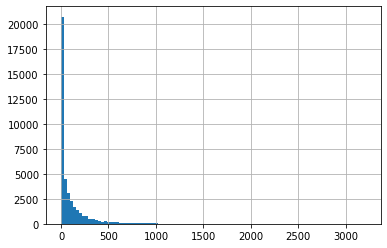

In [16]:
df.interval.hist(bins=100)

In [17]:
def make_hist(date,d0,d1):
    option=(df[date]>=d0) & (df[date]<=d1)
    df[option][date].hist(bins=100)
    return 0

d0='2017-10-01 00:00:00'
d1='2017-12-31 00:00:00'

#make_hist('d1',d0,d1)
#make_hist('d2',d0,d1)

In [18]:
# Подгрузим данные из Википедии по количесву жителей в европейских городах и подтянрем данные к нашему датасету
dfCities = pd.read_csv('Cities.csv', sep=';')
df = df.merge(dfCities, how='left')

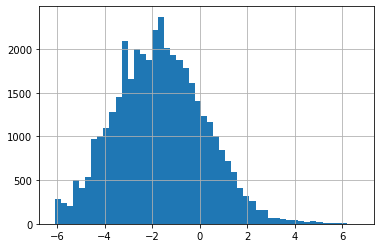

In [19]:
# 4. Обработка поля 'Number of Reviews'

Num_of_Rev = df[~df['Number of Reviews'].isna()][['City','Number of Reviews']].groupby(by='City').median()

df['Number of Reviews'] = df.apply(
    lambda x: Num_of_Rev.loc[x.City]['Number of Reviews'] \
    if isnan(x['Number of Reviews']) \
    else x['Number of Reviews'], axis=1)

# Взвесим на количество жителей
df['Num_of_Rev'] = (df['Number of Reviews']/df['Population']) * 10000
# И логарифимируем, что бы уйти от слишком большого разброса
df['Num_of_Rev'] = df['Num_of_Rev'].apply(math.log)
df['Num_of_Rev'].hist(bins=50)


In [20]:
# 5. Заполнение пропусков в поле 'Cuisine Style'.

# 5.1. Работаем только с строками, где 'Cuisine Style' заполнено (в датасете dx).
dx = pd.read_csv('main_task.csv')
dx = dx[~dx['Cuisine Style'].isna()].copy()
dx['Cuisine Style'] = dx['Cuisine Style'].apply(lambda x: [i.strip("'[]") for i in x.split(', ')])

# 5.2. Добавляем поле из количества различных стилей в каждом ресторане
dx.insert(3,'num_of_cuis', dx['Cuisine Style'].apply(lambda x: len(x)))

# 5.3. Разносим каждый из стилей кухонь по столбцам
list_to_columns (dx,'Cuisine Style')

# 5.4. Группируем датасет по городам и формируем для каждого города наиболее харакерные стили
Cities = pd.DataFrame(dx.groupby('City').sum())
Cities.drop(['Ranking','Rating','Number of Reviews'], axis=1, inplace=True)

Cities.insert(1, 'num_of_rest', dx['City'].value_counts())                          # Количество ресторанов в каждом городе
Cities.insert(2, 'cuis_per_rest', Cities['num_of_cuis']/Cities['num_of_rest'])      # Среднее количество стилей в ресторанах
Cities['cuis_per_rest'] = Cities['cuis_per_rest'].apply(lambda x: int(round(x,0)))

Cities.insert(3, 'all_uniq_cuis', Cities.apply(make_cuis_list, axis=1, args=[Cities,3]))  # Список уникальных стилей
Cities.insert(4, 'num_of_uniq_cuis', Cities['all_uniq_cuis'].apply(lambda x: len(x)))     # Количество уникальных стилей
Cities.insert(5, 'most_pop_cuis', Cities.apply(make_pop_cuis, axis=1, args=[Cities,5]))   # Топ самых популярных стилей

# 5.5. Заполняем отсутствующие данными в боевом датасете df стилями, наиболее характерными для каждого города
df['Cuisine Style'] = df.apply(
    lambda x: Cities.loc[x.City]['most_pop_cuis'] \
    if isnan(x['Cuisine Style']) \
    else [i.strip("'[]") for i in x['Cuisine Style'].split(', ')], axis=1)

df.insert(3,'num_of_cuis', df['Cuisine Style'].apply(lambda x: len(x)))
list_to_columns (df,'Cuisine Style')

0

In [21]:
# 6. Переводим города в поля датасета
list_to_columns (df,'City',not_a_list=True)

0

In [22]:
# 7. Нормализация поля Ranking
rang_by_city = df[['City','Ranking']].groupby(by='City').max()
df['Max_Rang'] = df.apply(lambda x: rang_by_city.loc[x.City], axis=1) 
df['Ranking']  = df['Ranking']/df['Max_Rang']
df.drop(columns=['Max_Rang'],inplace=True)

# 3. Разбиваем датафрейм на части, необходимые для обучения и тестирования модели. Создаём, обучаем и тестируем модель

In [23]:
df[df.columns[:19]].sample(1)

,City,Cuisine Style,Ranking,num_of_cuis,Rating,Price Range,Number of Reviews,d1,d2,d_len,rev_1,rev_2,mark_1,mark_2,mark,dynamic,interval,Population,Num_of_Rev
30210,Milan,[Italian],0.548526,1,5.0,0,50.0,2001-01-01,2001-01-01,0,,,0,0,0,0.0,0,1404239,-1.032643


In [24]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating','City','Cuisine Style','rev_1','rev_2','d1','d2','d_len','mark_1','mark_2'], axis = 1)
y = df['Rating']

In [25]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import train_test_split


In [26]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [27]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [28]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20788437499999998
